In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate , Add, Dot, Activation, Lambda, BatchNormalization, LeakyReLU, Softmax, ReLU
from tensorflow.keras.models import Model

from tensorflow.image import flip_up_down, flip_left_right, rot90
from tensorflow.linalg import normalize

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math

import matplotlib.pyplot as plt
import sys 
sys.path.append('..')
from layers.sorted_filters import SortedConv2D

import datetime


In [2]:
from tensorflow.python.client import device_lib
#tf.disable_v2_behavior()

#print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.__version__ )

Num GPUs Available:  1
2.9.1


In [3]:
input_net = Input((32, 32, 3))

y = SortedConv2D(filters=32,activation=LeakyReLU(alpha=0.1), padding='SAME')(input_net)
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 
#y = layers.Dropout(0.2)(y)
#y = layers.BatchNormalization(axis=-1)(y)


y = SortedConv2D(filters=64,activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
#y = SortedConv2D(filters=32,activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 
#y = layers.Dropout(0.2)(y)
#y = layers.BatchNormalization(axis=-1)(y)

y = SortedConv2D(filters=128, activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
#y = SortedConv2D(filters=64, activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
#y = SortedConv2D(filters=64, activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 
y = layers.Dropout(0.5)(y)
y = layers.BatchNormalization(axis=-1)(y)

y = layers.Flatten()(y)
y = layers.Dense(1000, activation=ReLU())(y)
y = layers.BatchNormalization(axis=-1)(y)
y = layers.Dropout(0.5)(y)
output_net  = layers.Dense(100, activation=Softmax())(y)

model = Model(inputs = input_net, outputs = output_net)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sorted_conv2d (SortedConv2D  (None, 32, 32, 32)       322       
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 sorted_conv2d_1 (SortedConv  (None, 16, 16, 64)       6210      
 2D)                                                             
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                         

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


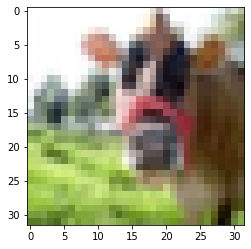

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()



# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

plt.imshow(x_train[0,:,:,:])

In [5]:
model = Model(inputs = input_net, outputs = output_net)

initial_learning_rate =  0.01

lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    alpha = 1e-6,
    m_mul=0.999,
    first_decay_steps = 20)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
)


checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

batch_size = 200
epochs = 100
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/100
196/196 [==============================] - 14s 43ms/step - loss: 4.8989 - accuracy: 0.0457 - top-5-accuracy: 0.1592 - val_loss: 5.0951 - val_accuracy: 0.0499 - val_top-5-accuracy: 0.1736
Epoch 2/100
196/196 [==============================] - 7s 36ms/step - loss: 4.1489 - accuracy: 0.0772 - top-5-accuracy: 0.2401 - val_loss: 5.2840 - val_accuracy: 0.0509 - val_top-5-accuracy: 0.1630
Epoch 3/100
196/196 [==============================] - 7s 36ms/step - loss: 4.0093 - accuracy: 0.0939 - top-5-accuracy: 0.2745 - val_loss: 3.9100 - val_accuracy: 0.1109 - val_top-5-accuracy: 0.3131
Epoch 4/100
196/196 [==============================] - 8s 40ms/step - loss: 4.0274 - accuracy: 0.0873 - top-5-accuracy: 0.2682 - val_loss: 4.0650 - val_accuracy: 0.0893 - val_top-5-accuracy: 0.2593
Epoch 5/100
196/196 [==============================] - 8s 39ms/step - loss: 3.9767 - accuracy: 0.0944 - top-5-accuracy: 0.2872 - val_loss: 4.0941 - val_accuracy: 0.0889 - val_top-5-accuracy: 0.2753
Epoch 6/1

In [6]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


1/1 [==============================] - 0s 393ms/step
[59] 59
(1, 32, 32, 32)
[[-1.3794416e+00 -8.2113139e-02  1.4841726e-01 ...  1.1873990e+00
   1.3608999e+00  1.5951307e+01]
 [-2.0763617e+00 -1.4845617e-01  1.5779504e-01 ...  1.7994130e+00
   2.0685401e+00  2.3921431e+01]
 [-2.1044247e+00 -1.7797734e-01  3.6411235e-01 ...  1.8074435e+00
   2.1119223e+00  2.4060289e+01]
 ...
 [-1.1623683e-01 -2.5079792e-02 -1.2935462e-02 ...  1.5926211e-01
   2.7487326e-01  1.7619323e+00]
 [-1.0491550e-01 -2.0203495e-02 -8.1812060e-03 ...  1.5879744e-01
   1.3716942e-01  1.6274978e+00]
 [-6.4651750e-02 -1.1729865e-02 -1.8704087e-03 ...  1.1182850e-01
   5.2640572e-02  1.1241606e+00]]


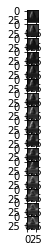

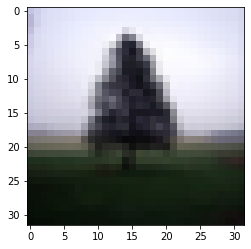

In [7]:
get_layer_output = K.function([model.input], model.layers[1].output)

n = 109

X = np.expand_dims(x_test[n], axis=0)
print(y_test[n], np.argmax(model.predict(X)))


layer_out = np.array(get_layer_output([X]))
print(layer_out.shape)

print(layer_out[0, :,:, 0])
fig, ax = plt.subplots(16)
for i in range(16):
    ax[i].imshow(layer_out[0, :,:, i],  cmap='gray')   

plt.figure(2)  
plt.imshow(x_test[n],  cmap='gray')   

 

In [8]:
model.layers[4].trainable_variables[3].name

IndexError: list index out of range

In [ ]:
model.layers[1].gain

<tf.Variable 'sorted_conv2d/gain:0' shape=(16,) dtype=float32, numpy=
array([ 0.11939116,  0.05609927, -0.06869635,  0.20617014,  0.4875158 ,
        1.3473631 , -0.2961605 ,  0.7719101 ,  1.1405659 ,  0.5420837 ,
        1.0014944 ,  0.07880694,  0.03514984,  0.71787316,  0.04205557,
        0.33719826], dtype=float32)>

In [ ]:
model.layers[5].scale_a

<tf.Variable 'sorted_conv2d_2/scale_asym:0' shape=() dtype=float32, numpy=-0.16710012>